# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

In [1]:
from typing import Any

from numpy import floating
!pip install transformers torch  # For BERT
!pip install -r requirements.txt
# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT

In [2]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    BERT_AVAILABLE = True
    print("BERT libraries loaded successfully!")
    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    print(f"Using device: {device}")
except ImportError:
    BERT_AVAILABLE = False
    print("BERT libraries not available. Install with: pip install transformers torch")

Check the status of BERT installation:


/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERT libraries loaded successfully!
Using device: cuda


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import re
import time, math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(10)

print("Libraries imported successfully!")

Libraries imported successfully!


# Load dataset

In [4]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv('data/training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv('data/test.txt', sep='\t', names=columns_name)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')

The training data:


user_id  item_id  rating
0        1        1       5
1        1        2       3
2        1        3       4
3        1        4       3
4        1        5       3

The shape of the training data: (80000, 4)
--------------------------------
The test data:


user_id  item_id  rating
0        1        6       5
1        1       10       3
2        1       12       5
3        1       14       5
4        1       17       3

The shape of the test data: (20000, 4)


In [5]:
movies = pd.read_csv('data/movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

item_id              title                         genres  \
0        1   Toy Story (1995)  Animation, Children's, Comedy   
1        2   GoldenEye (1995)    Action, Adventure, Thriller   
2        3  Four Rooms (1995)                       Thriller   
3        4  Get Shorty (1995)          Action, Comedy, Drama   
4        5     Copycat (1995)         Crime, Drama, Thriller   

                                         description  
0  A group of sentient toys, who pretend to be li...  
1  In 1986, MI6 agents James Bond and Alec Trevel...  
2  On New Year's Eve, bellhop Sam (Marc Lawrence)...  
3  Chili Palmer is a Miami-based loan shark and m...  
4  After giving a guest lecture on criminal psych...

# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

In [6]:
from recommendation_algorithms.hybrid_recommender import HybridRecommender
from recommendation_algorithms.matrix_factorization import MatrixFactorizationSGD
from recommendation_algorithms.bayesian_probabilistic_ranking import BayesianProbabilisticRanking
from recommendation_algorithms.item_knn import ItemKNN

# TODO add others
matrix_factorization = MatrixFactorizationSGD()
bpr = BayesianProbabilisticRanking()
rating_recommenders = [matrix_factorization]
ranking_recommenders = [matrix_factorization, bpr]
max_k = 10 # Recommendation list size
hybrid_recommender = HybridRecommender(train_data, rating_recommenders, ranking_recommenders, max_k, True)

Started training hybrid recommender on 943 users and 1650 items...
Training individual models...


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


Finished training individual models.
Started linear regression...
[INFO] Visualization saved to: plots/linear_regression_rating_2025-10-23_15-46-36.png
Finished rating linear regression, weights are:
  Matrix Factorization: 1.0054005611374413
Finished ranking linear regression, weights are:
  Matrix Factorization: 0.5
  Bayesian Probabilistic Ranking: 0.5
Precomputing predictions...
Finished computing predictions, model is ready to use.


In [7]:
user_id = 1
item_id = 2
predicted_score = hybrid_recommender.predict_score(user_id, item_id)
actual_score = train_data.loc[((train_data['user_id'] == user_id) & (train_data['item_id'] == item_id)), 'rating'].values[0]
print(f'Predicted score {predicted_score} for user {user_id} and item {item_id}, actual score: {actual_score}.')

predicted_ranking = hybrid_recommender.predict_ranking(user_id, max_k)
print(f"Predicted ranking for user {user_id}")
for i in range(len(predicted_ranking)):
    print(f"  {i + 1}: {predicted_ranking[i]}")

Predicted score 3.059097456602252 for user 1 and item 2, actual score: 3.
Predicted ranking for user 1
  1: (np.float64(276.0), np.float64(2.544232296045881))
  2: (np.float64(100.0), np.float64(2.524134911059497))
  3: (np.float64(318.0), np.float64(2.4717436182296435))
  4: (np.float64(483.0), np.float64(2.444912912882284))
  5: (np.float64(50.0), np.float64(2.4369152190698156))
  6: (np.float64(191.0), np.float64(2.4356222128228513))
  7: (np.float64(151.0), np.float64(2.4193288068517727))
  8: (np.float64(174.0), np.float64(2.413345689642898))
  9: (np.float64(357.0), np.float64(2.407086181586917))
  10: (np.float64(172.0), np.float64(2.3924889033024628))


#### Test BPR Out 

In [8]:
from recommendation_algorithms.bayesian_probabilistic_ranking import BayesianProbabilisticRanking

bpr = BayesianProbabilisticRanking()
bpr.train(train_data)   

#### User-based Collaborative Filtering

In [7]:
from recommendation_algorithms.user_knn import UserKNN

In [5]:
u_knn = UserKNN(2)

df = pd.DataFrame({
    'user_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4, 4],
    'item_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 2],
    'rating':  [5, 4, 3, 3, 4, 3, 2, 4, 5, 5, 3]
})

u_knn.train(df)

4it [00:00, 697.74it/s]


In [6]:
u_knn.predict_score(4, 3)

users_that_rated_i: 
[1, 2, 3]
sim_matrix_masked: 
          1    2         3    4
1  0.000000  0.0 -0.755929  1.0
2  0.000000  0.0  0.000000  0.0
3 -0.755929  0.0  0.000000  0.0
sims: 
2    0.000000
1   -0.755929
Name: 3, dtype: float64
ni 
[2 1]
rvi 
[4 2]
rv 
[4.         3.33333333]


np.float64(5.333333333333334)

### Item-based Collaborative Filtering

In [48]:
from recommendation_algorithms.item_knn import ItemKNN

In [49]:
i_knn = ItemKNN(2)

df = pd.DataFrame({
    'user_id': [1, 2, 3, 1, 2, 3, 1, 2, 3, 4, 4],
    'item_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 2],
    'rating':  [5, 4, 3, 3, 4, 3, 2, 4, 5, 5, 3]
})

i_knn.train(df)




3it [00:00, 1528.35it/s]


In [50]:
i_knn.predict_score(4, 3)

np.float64(3.954941986653667)

# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

## Code

## Evaluation scripts

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


### Rating task

In [2]:
# EVALUATION functions
from sklearn.metrics import root_mean_squared_error

def evaluate_rating(ground_truth: list[float], predictions: list[float]) -> float:
    """
    Evaluation function for one model for rating prediction task - RMSE. Takes two lists of rating values as input and returns RMSE and MSE. Assumes that the two lists are aligned (i.e., the i-th element in each list corresponds to the same user-item pair).

    :param ground_truth: list of actual ratings
    :param predictions:  list of predicted ratings
    :return: float
    """
    return root_mean_squared_error(ground_truth, predictions)

def evaluate_rating_all():
    pass

In [3]:
# DEBUG - example

gt = [4.0, 3.5, 5.0, 2.0]
preds = [3.5, 3.0, 4.5, 2.5]

rmse = evaluate_rating(gt, preds)
print(f'RMSE: {rmse:.4f}')

RMSE: 0.5000


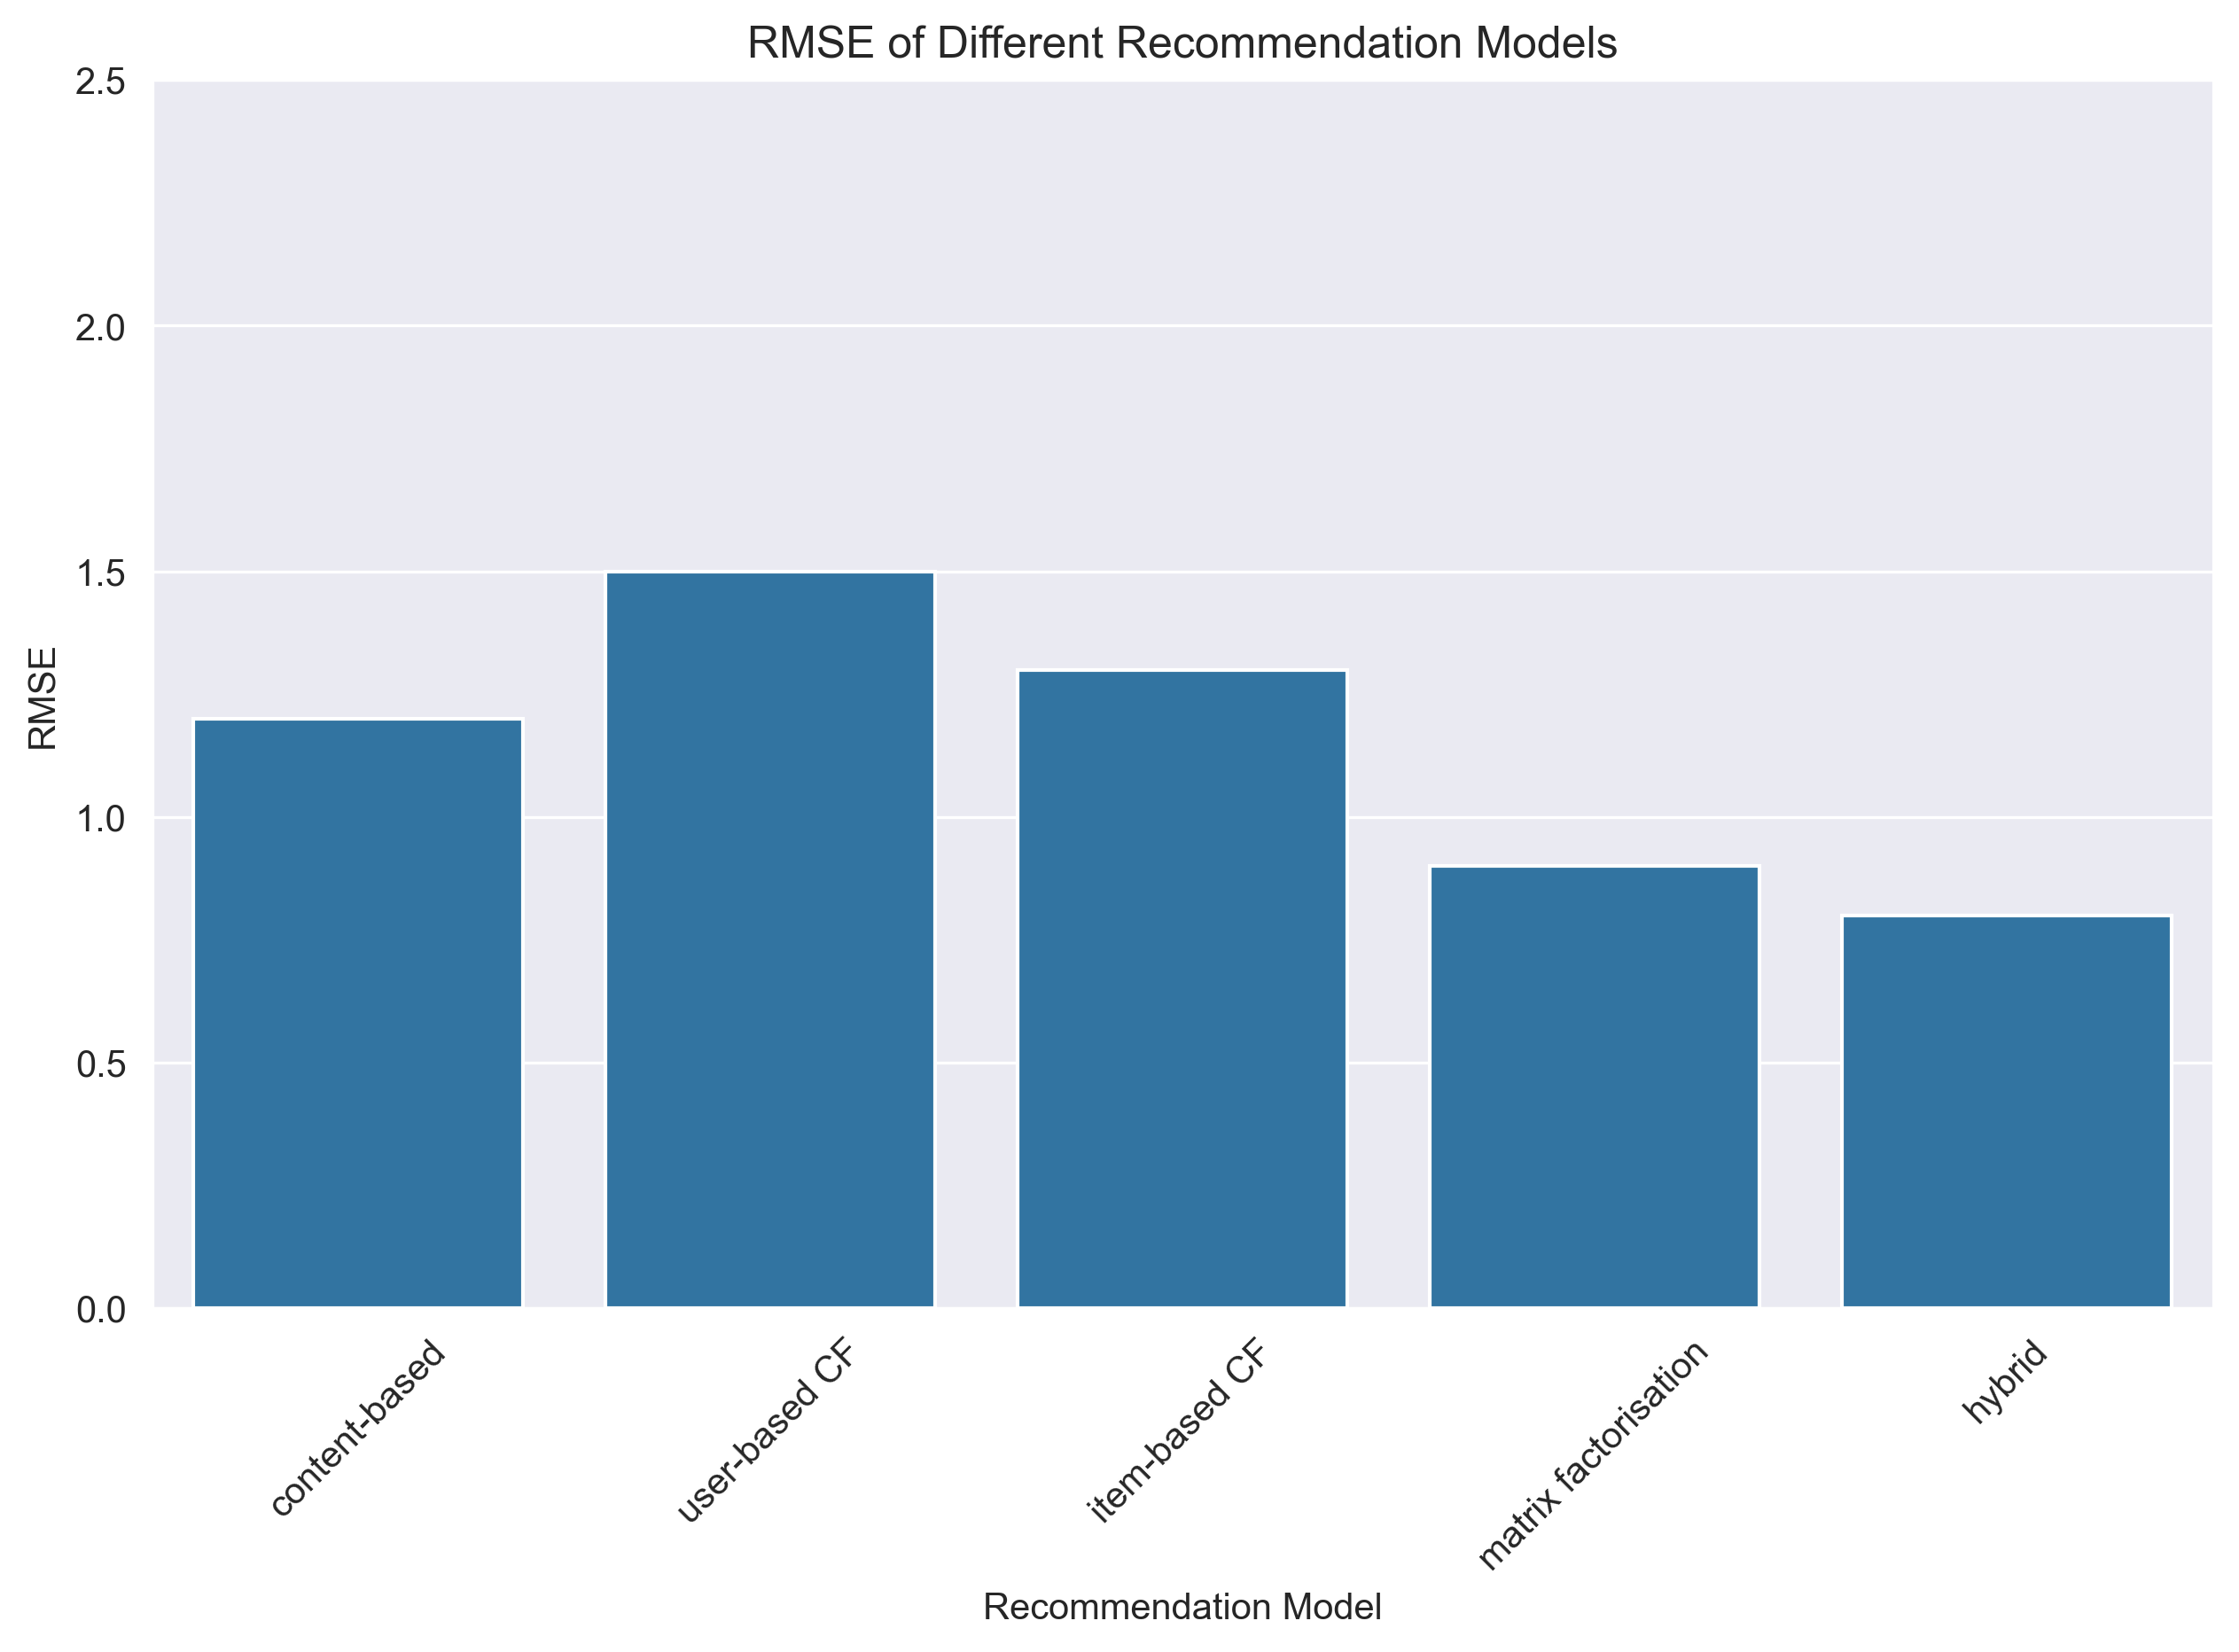

In [19]:
# VISUALISATION

results_rating = {
    'content-based' : 1.2,
    'user-based CF' : 1.5,
    'item-based CF' : 1.3,
    'matrix factorisation' : 0.9,
    'hybrid' : 0.8,
}

def plot_rating_results(results: dict):
    """
    Plot RMSE results for different recommendation models. (This function was generated using Copilot, then debugged)

    :param results: dictionary where keys are model names and values are RMSE scores
    """
    models = list(results.keys())
    rmse_scores = list(results.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=rmse_scores)
    plt.title('RMSE of Different Recommendation Models')
    plt.xlabel('Recommendation Model')
    plt.ylabel('RMSE')
    plt.ylim(0, max(rmse_scores) + 1)
    plt.xticks(rotation=45)  # readability
    plt.show()

plot_rating_results(results_rating)

### Ranking task

In [8]:
# Evaluation ranking task

def ndcg(ground_truth, rec_list, k = 10) -> float:
    if k > len(rec_list):
        k = len(rec_list)
    dcg = 0.0
    for i in range(k):
        numerator = 1 if rec_list[i] in ground_truth else 0
        denominator = np.log2(i + 2)
        dcg += numerator / denominator
    ideal_len = min(k, len(ground_truth))
    if ideal_len == 0:
        return 0.0
    else:
        IDCG = sum(1.0 / np.log2(i + 2) for i in range(ideal_len))
        return dcg / IDCG


def evaluate_ranking(ground_truth: list[list], rec_list: list[list], k=10) -> tuple[
    floating[Any], floating[Any], floating[Any]]:
    """
    Calculate Precision, Recall, and NDCG for ranking task.

    Assume that items in rec_list are relevant (rel = 1) and items not in rec_list are non-relevant (rel = 0).

    :param ground_truth: lists of list of item ids that are relevant
    :param rec_list: list of recommended top-k item ids
    :param k: cut-off for ndcg (may change to be for P and R as well) - TODO
    :return:
    """
    # Compute Precision & Recall
    len_intersections = np.array([len(set(gt).intersection(set(rl))) for rl, gt in zip(rec_list, ground_truth)])
    len_rls = np.array([len(rl) for rl in rec_list])
    len_gts = np.array([len(gt) for gt in ground_truth])

    p = np.nanmean(100 * len_intersections / len_rls)  # precision
    r = np.nanmean(100 * len_intersections / len_gts)  # recall

    # Compute NDCG
    ndcgs = [ndcg(gt, rl, k) for rl, gt in zip(rec_list, ground_truth)]
    ndcg_mean = np.mean(ndcgs)

    return p, r, ndcg_mean

def evaluate_ranking_all():
    pass

In [9]:
# DEBUG - example use

ground_truth = [[1, 2, 3], [2, 3, 4], [1, 4]]
rec_list = [[2, 3, 5], [1, 2, 3], [4, 5, 6]]

precision, recall, ndcg_mean = evaluate_ranking(ground_truth, rec_list, k=3)
print(f'Precision: {precision:.2f}%, Recall: {recall:.2f}%, NDCG: {ndcg_mean:.4f}')

Precision: 55.56%, Recall: 61.11%, NDCG: 0.6364


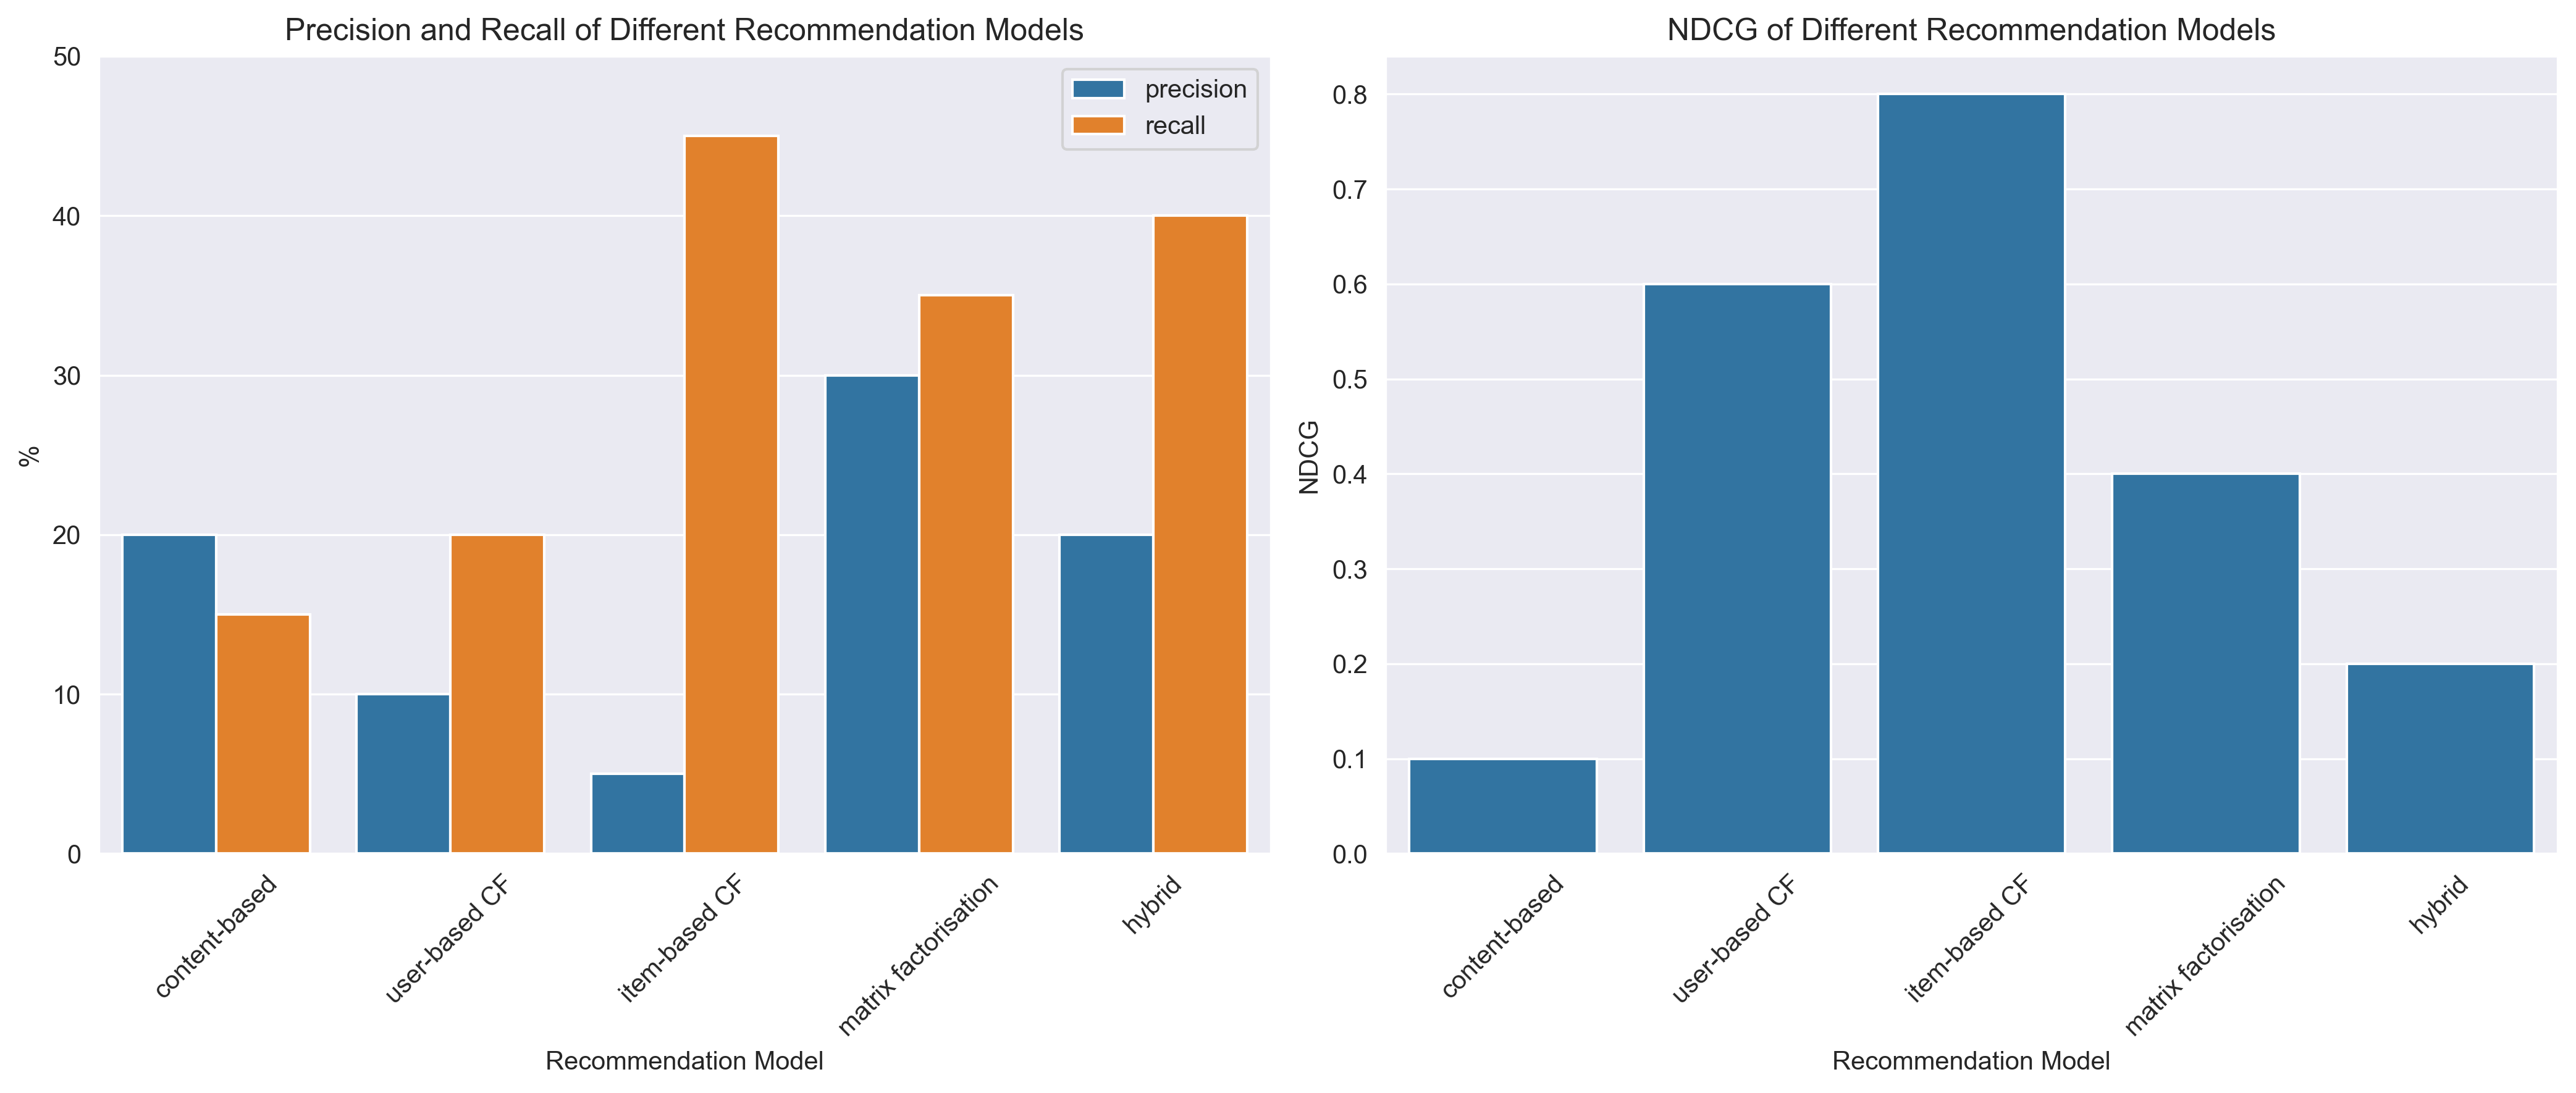

In [60]:
# VISUALISATION

results_ranking = {  # [precision, recall, ndcg]
    'content-based' : [20.0, 15.0, 0.1],
    'user-based CF' : [10.0, 20.0, 0.6],
    'item-based CF' : [05.0, 45.0, 0.8],
    'matrix factorisation' : [30.0, 35.0, 0.4],
    'hybrid' : [20.0, 40.0, 0.2],
}


def visualise_ranking_results(results: dict, tight: bool = False):
    """
    Plot Precision and Recall, and NDCG results for different recommendation models.

    :param tight: whether to display the two plots (Precision & Recall, NDCG) side by side
    :param results: dictionary where keys are model names and values are lists of [precision, recall, ndcg]
    """
    df = pd.DataFrame.from_dict(results, orient='index', columns=['precision', 'recall', 'ndcg']).reset_index().rename(columns={'index': 'model'})
    df_melt = df.melt(id_vars='model', value_vars=['precision', 'recall'], var_name='metric', value_name='value')

    if not tight:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_melt, x='model', y='value', hue='metric', palette=['tab:blue', 'tab:orange'], errorbar=None)
        plt.title('Precision and Recall of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('%')
        plt.xticks(rotation=45)  # readability
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None)
        plt.title('NDCG of Different Recommendation Models')
        plt.xlabel('Recommendation Model')
        plt.ylabel('NDCG')
        plt.xticks(rotation=45)

    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        # Left - grouped Precision & Recall
        sns.barplot(data=df_melt, x='model', y='value', hue='metric',
                    palette=['tab:blue', 'tab:orange'], errorbar=None, ax=axes[0])
        axes[0].set_title('Precision and Recall of Different Recommendation Models')
        axes[0].set_xlabel('Recommendation Model')
        axes[0].set_ylabel('%')
        axes[0].set_ylim(0, df_melt['value'].max() + 5)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].legend(title=None)

        # Right - NDCG
        sns.barplot(data=df, x='model', y='ndcg', errorbar=None, ax=axes[1])
        axes[1].set_title('NDCG of Different Recommendation Models')
        axes[1].set_xlabel('Recommendation Model')
        axes[1].set_ylabel('NDCG')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
    plt.show()

visualise_ranking_results(results_ranking, tight=True)

# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

## Code

## Evaluation

You should be able to use the evaluation functions defined in Task 2 for evaluating the baselines as well (`evaluate_rating` and `evaluate_ranking`). Just call these for the combination of ground truth with the different predictions from the baselines.

# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups. 

# Task 5) Evaluation of beyond accuracy

## Diversity - ILD

- intra-list diversity - ILD - average pairwise distance
$$
ILD(L) = \frac{1}{|L|(|L|-1)} \sum_{i,j \in L}dist(i,j)
$$
- $dist(i,j)$ - distance function of how different $i$ and $j$ are
	- eg, embedding distance, categorical distance

In [ ]:
def diversity(rec_list, dist_func):
    """
    Calculate intra-list diversity (ILD) for a given recommendation list using a specified distance function.
    :param rec_list: top-k recommended item ids
    :param dist_func: function taking two item ids and returning a distance value - TODO - update / fix
    :return:
    """
    if len(rec_list) <= 1:
        return 0.0
    L = len(rec_list)
    frac = 1 / (L * (L - 1))
    total_dist = np.sum([dist_func(i,j) for i in rec_list for j in rec_list])

    return frac * total_dist

\[Discussion]

## Novelty - surprisal
- **self-information** - surprisal - measures how “surprising” an item is, based on its popularity
$$
novelty(i) = -\log_{2} pop(i)
$$

- $pop(i)$ - popularity of item $i$ - percentage of interactions on item $i$ = $\frac{num\_interactions\_on\_i}{total\_num\_interactions}$
  - from training data only?

In [ ]:
def novelty(item, train_data):
    pass

\[Discussion]

## Calibration

**Calibration metric** - Kullback-Leibler divergence (lower = better) - ?
$$
MC_{KL}(p,q) = KL(p||q) = \sum_{g} p(g|u) \log \frac{p(g|u)}{q(g|u)}
$$

In [ ]:
def calibration():
    pass

\[Discussion]

## Fairness

Types:
- User-side - RecSys serve individual users/groups equally
    - Group Recommendation Unfairness - GRU
    - User Popularity Deviation - UPD
- Item-side - fair representation of items \<--
    - catalog coverage - fraction of items recommended at least once (need results for all rankings (item-user pairs))
    - equality of exposure - entropy, gini index
    - demographic parity - exposure to each group should be $\propto$ group size
    - disparate treatment - exposure to each group should be $\propto$ group utility / merit
    - disparate impact - exposure to each group should be according to expected group attention to group utility/merit

\[Discussion]

# Questions for feedback session
- **Diversity** - distance metric - which to use? Difference in rating, content differences, embedding differences?
- **Novelty** - surprisal - is this more for the rating task since it focuses on the (recommended) item?
- **Calibration** - Kullback-Leibler divergence - is this the right metric? do we need extra information from the database to compute this? (EG, genre information)
- **Fairness** - which metric to use? do we need extra information from the database to compute